<a href="https://colab.research.google.com/github/yahal2005/Facial-Emotion-Recognition/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from sklearn.utils import shuffle
from collections import Counter

In [11]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Colab_Notebooks/fer'
haarcascade_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haarcascade_path)

ck_path = os.path.join(base_path, 'CK_dataset')
jaffe_path = os.path.join(base_path, 'JAFFE')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
def detect_and_crop_faces(folder_path,face_cascade):
    """
    Scans the folder, finds faces using Haar Cascade, crops them,
    and resizes them to 64x64.
    Returns: Clean arrays of Face Images and Labels.
    """
    images = []
    labels = []


    if not os.path.exists(folder_path):
        print(f"Error: Folder not found: {folder_path}")
        return np.array([]), np.array([])

    print(f"Scanning & Detecting Faces")

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            count = 0
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    # Detect Face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                    if len(faces) > 0:
                        # Crop the first face found
                        (x, y, w, h) = faces[0]
                        face_roi = img[y:y+h, x:x+w]

                        # Resize to standard 64x64
                        face_roi = cv2.resize(face_roi, (64, 64))

                        images.append(face_roi)
                        labels.append(label)
                        count += 1
            print(f"     - Class '{label}': Found {count} faces.")

    return np.array(images), np.array(labels)

In [5]:
def augment_data(images, labels):
    """
    Doubles the data by flipping horizontally.
    ONLY run this on training data.
    """
    augmented_images = []
    augmented_labels = []

    print("   Augmenting data (Horizontal Flipping)...")
    for img, label in zip(images, labels):
        # 1. Original
        augmented_images.append(img)
        augmented_labels.append(label)

        # 2. Flipped (Augmentation)
        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)
        augmented_labels.append(label)

    print(f"   -> New size: {len(augmented_images)}")
    return np.array(augmented_images), np.array(augmented_labels)

In [6]:
def extract_hog_features(images):
  """
    Extracts Histogram of Oriented Gradients (HOG) features.
  """
  hog_features = []
  print("Extracting HOG features...")
  for img in images:
    img = cv2.resize(img, (64, 64))
    hog_feat = hog(img,orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2), block_norm='L2-Hys')
    hog_features.append(hog_feat)
  return np.array(hog_features)

In [16]:
def generate_all_graphs(model, X_train, y_train, X_test, y_test, y_pred, X_img_test):
    """
    Generates all 3 mandatory figures for the assignment:
    1. Confusion Matrix (Heatmap)
    2. Learning Curve (The 'Loss Graph' equivalent)
    3. Sample Predictions (Visual proof of classification)
    """

    # --- GRAPH 1: CONFUSION MATRIX ---
    # Shows exactly where the model is getting confused (e.g., Happy vs Neutral)
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Figure 1: Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    print("Graph 1 Generated: Confusion Matrix (Check for dark diagonal squares)")


    # --- GRAPH 2: SAMPLE PREDICTIONS (Visual Proof) ---
    print("\nGenerating Visual Predictions...")

    # Pick 5 random images from the test set
    num_samples = 5
    indices = np.random.choice(len(X_img_test), num_samples, replace=False)

    plt.figure(figsize=(15, 4))

    for i, idx in enumerate(indices):
        # Get the original image and label
        img = X_img_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred[idx] # We already calculated predictions earlier

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')

        # Color code the title: Green if correct, Red if wrong
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle('Figure 2: Sample Visual Predictions')
    plt.show()

In [24]:
def analyze_grid_results(grid, X_train, y_train):
    """
    Comprehensive Analysis Function. Generates:
    1. Statistical Report of the best model.
    2. Graph: Impact of Gamma (if RBF).
    3. Graph: Comparative Learning Curves for ALL Kernels (Linear vs RBF vs Poly).
    """
    results = grid.cv_results_
    means = results['mean_test_score']
    params = results['params']

    # --- PART 1: TEXT REPORT ---
    best_index = grid.best_index_
    print(f"\n{'='*40}")
    print(f"🏆 BEST MODEL PERFORMANCE ANALYSIS")
    print(f"{'='*40}")
    print(f"Best Kernel:        {grid.best_params_['kernel'].upper()}")
    print(f"Best Mean CV Acc:   {means[best_index]*100:.2f}%")
    print(f"Best Parameters:    {grid.best_params_}")

    # --- PART 2: GRAPH - IMPACT OF GAMMA (For RBF) ---
    # We only plot this if RBF is present
    if any(p['kernel'] == 'rbf' for p in params):
        # Find best C to isolate Gamma's effect
        best_c = grid.best_params_['C']
        gammas = []
        scores = []
        for mean, param in zip(means, params):
            if param['kernel'] == 'rbf' and param['C'] == best_c:
                gammas.append(param['gamma'])
                scores.append(mean)

        if gammas:
            plt.figure(figsize=(6, 4))
            # Sort for clean line plot
            sorted_idx = np.argsort(gammas)
            plt.plot(np.array(gammas)[sorted_idx], np.array(scores)[sorted_idx], 'o-', color='purple')
            plt.xscale('log')
            plt.title(f'Effect of Gamma (RBF Kernel, C={best_c})')
            plt.xlabel('Gamma')
            plt.ylabel('CV Accuracy')
            plt.grid(True)
            plt.show()

    # --- PART 3: GRAPH - KERNEL COMPARISON LEARNING CURVES ---
    print("\nGenerating Kernel Comparison Learning Curves (This takes a moment)...")

    # 1. Find best params for EACH kernel type
    best_params_by_kernel = {}
    for mean, param in zip(means, params):
        k = param['kernel']
        if k not in best_params_by_kernel or mean > best_params_by_kernel[k]['score']:
            best_params_by_kernel[k] = {'score': mean, 'params': param}

    # 2. Setup Subplots
    kernels_found = list(best_params_by_kernel.keys())
    fig, axes = plt.subplots(1, len(kernels_found), figsize=(6 * len(kernels_found), 5), sharey=True)
    if len(kernels_found) == 1: axes = [axes] # Handle single kernel case

    colors = {'linear': 'red', 'rbf': 'green', 'poly': 'blue'}

    for i, kernel in enumerate(kernels_found):
        # Re-create model with best params for THIS kernel
        p = best_params_by_kernel[kernel]['params']
        model = SVC(class_weight='balanced', **p)

        # Calculate Curve
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
        )

        # Plot
        ax = axes[i]
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        ax.plot(train_sizes, train_mean, 'o--', color="gray", alpha=0.5, label="Training")
        ax.plot(train_sizes, test_mean, 'o-', color=colors.get(kernel, 'black'), linewidth=2, label="Validation")
        ax.set_title(f"{kernel.upper()} (Acc: {best_params_by_kernel[kernel]['score']*100:.1f}%)")
        ax.set_xlabel("Training Samples")
        ax.grid(True)
        if i == 0: ax.set_ylabel("Accuracy")
        ax.legend(loc="best")

    plt.suptitle("Comparative Learning Curves: Justification for Kernel Selection")
    plt.tight_layout()
    plt.show()

In [25]:
def process(TRAIN_PATH, TEST_PATH):

  # 1. Detect
  X_train_raw, y_train_raw = detect_and_crop_faces(TRAIN_PATH,face_cascade)

  if len(X_train_raw) > 0:
      # B. Augment (Double the training data)
      X_img_train, y_train = augment_data(X_train_raw, y_train_raw)
  else:
      print("Error: No training data found.")

  # 2. PREPARE TEST DATA
  print("\n--- STEP 2: PREPARING TEST DATA ---")
  # Test data is ONLY detected. NEVER augmented.
  X_img_test, y_test = detect_and_crop_faces(TEST_PATH, face_cascade)

  if len(X_img_train) > 0 and len(X_img_test) > 0:
      # 3. Extract Features
      X_train_hog = extract_hog_features(X_img_train)
      X_test_hog = extract_hog_features(X_img_test)

      X_train_hog, y_train = shuffle(X_train_hog, y_train, random_state=42)

      # 4. Grid Search (CV + Training)
      print("\n--- TUNING & TRAINING ---")
      param_grid = [
        # Case 1: RBF Kernel (The favorite)
        {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},

        # Case 2: Linear Kernel (The baseline)
        {'C': [1, 10, 100], 'kernel': ['linear']},

        # Case 3: Polynomial Kernel (Limit degree to prevent timeouts)
        {'C': [1, 10], 'degree': [2, 3], 'kernel': ['poly']}
      ]

      svm = SVC(class_weight='balanced')
      cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

      # verbose=2 will show you exactly which kernel is being tested in real-time
      grid = GridSearchCV(svm, param_grid, cv=cv, n_jobs=-1, verbose=2)

      grid.fit(X_train_hog, y_train)
      analyze_grid_results(grid,X_train_hog, y_train)

      best_model = grid.best_estimator_
      print(f" Best Kernel Found: {grid.best_params_['kernel']}")
      print(f" Best Params: {grid.best_params_}")

      # 5. Evaluate
      y_pred = best_model.predict(X_test_hog)
      acc = accuracy_score(y_test, y_pred)
      print(f"\nFINAL TEST ACCURACY: {acc*100:.2f}%")
      print(classification_report(y_test, y_pred))

      # 6. Graphs
      generate_all_graphs(best_model, X_train_hog, y_train, X_test_hog, y_test, y_pred, X_img_test)

  else:
      print("Error: Not enough data loaded. Check paths.")

Scanning & Detecting Faces
     - Class 'fear': Found 16 faces.
     - Class 'anger': Found 40 faces.
     - Class 'happy': Found 75 faces.
     - Class 'sadness': Found 41 faces.
     - Class 'neutral': Found 86 faces.
     - Class 'surprise': Found 82 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 680

--- STEP 2: PREPARING TEST DATA ---
Scanning & Detecting Faces
     - Class 'fear': Found 7 faces.
     - Class 'neutral': Found 36 faces.
     - Class 'anger': Found 18 faces.
     - Class 'happy': Found 30 faces.
     - Class 'surprise': Found 34 faces.
     - Class 'sadness': Found 17 faces.
Extracting HOG features...
Extracting HOG features...

--- TUNING & TRAINING ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

🏆 BEST MODEL PERFORMANCE ANALYSIS
Best Kernel:        RBF
Best Mean CV Acc:   72.35%
Best Parameters:    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


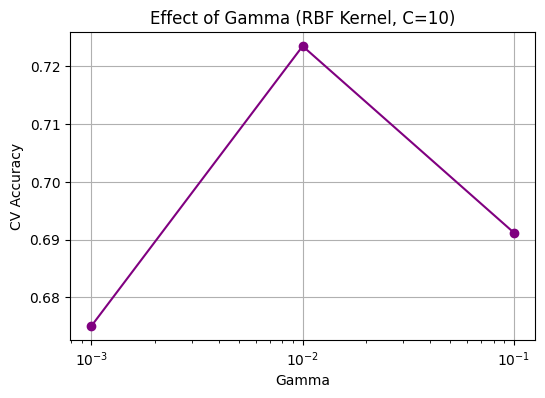


Generating Kernel Comparison Learning Curves (This takes a moment)...


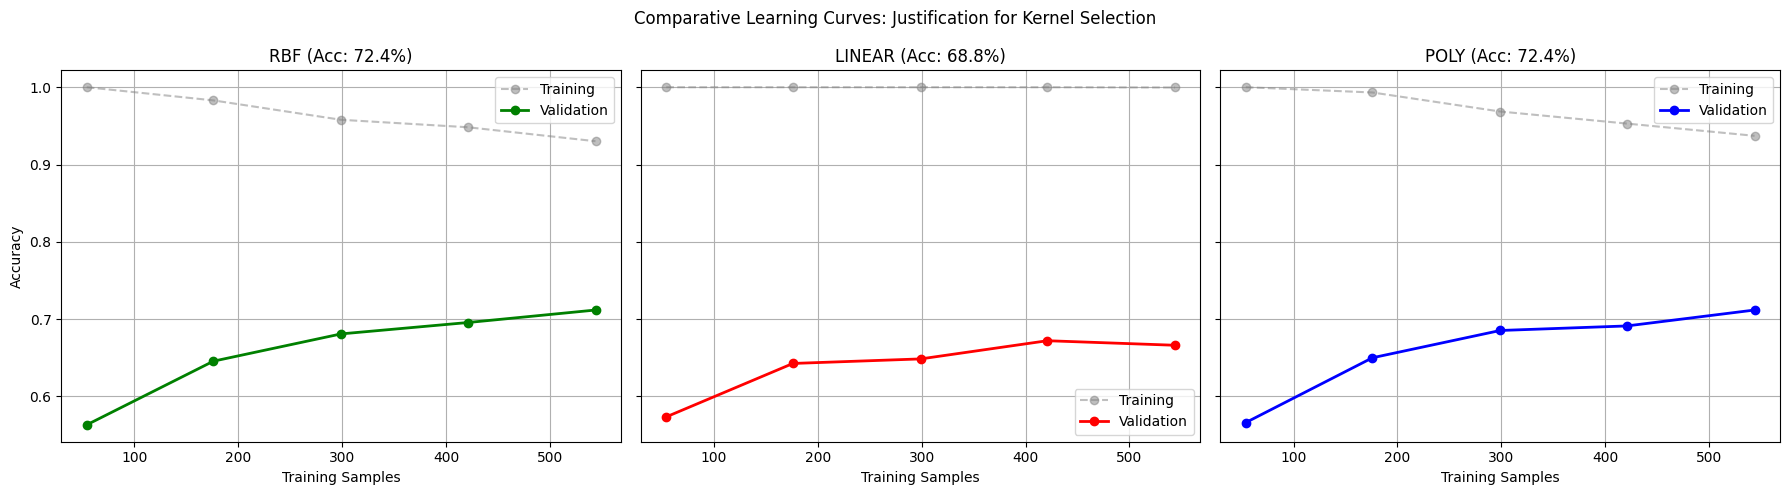

 Best Kernel Found: rbf
 Best Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

FINAL TEST ACCURACY: 64.08%
              precision    recall  f1-score   support

       anger       0.89      0.44      0.59        18
        fear       0.00      0.00      0.00         7
       happy       0.93      0.87      0.90        30
     neutral       0.48      0.78      0.60        36
     sadness       0.33      0.35      0.34        17
    surprise       0.92      0.68      0.78        34

    accuracy                           0.64       142
   macro avg       0.59      0.52      0.53       142
weighted avg       0.69      0.64      0.64       142



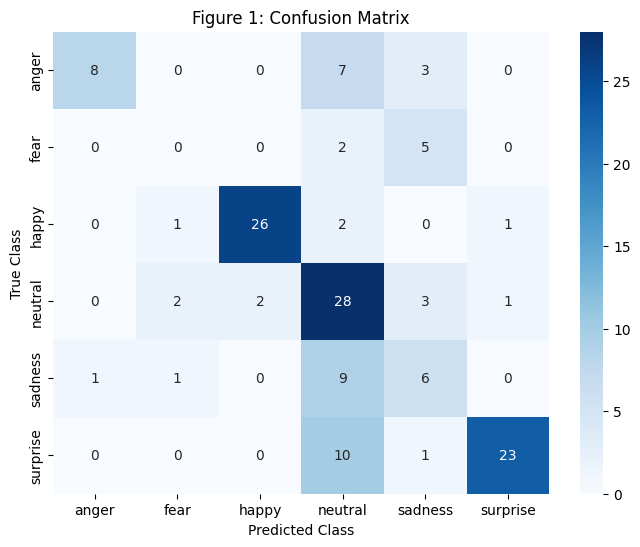

Graph 1 Generated: Confusion Matrix (Check for dark diagonal squares)

Generating Visual Predictions...


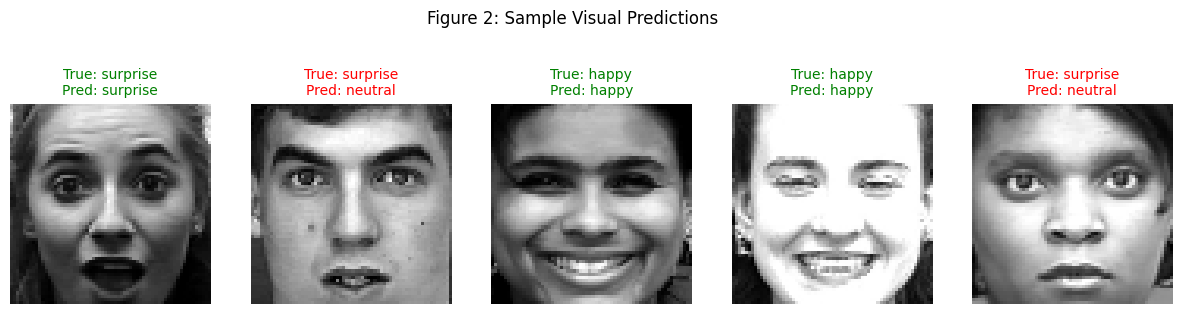

In [26]:
train_path = os.path.join(ck_path,'train')
test_path = os.path.join(ck_path,'test')
process(train_path, test_path)

Scanning & Detecting Faces
     - Class 'Angry': Found 20 faces.
     - Class 'Fear': Found 22 faces.
     - Class 'Happy': Found 22 faces.
     - Class 'Surprise': Found 21 faces.
     - Class 'Sad': Found 22 faces.
     - Class 'Neutral': Found 21 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 256

--- STEP 2: PREPARING TEST DATA ---
Scanning & Detecting Faces
     - Class 'Happy': Found 9 faces.
     - Class 'Angry': Found 9 faces.
     - Class 'Fear': Found 10 faces.
     - Class 'Neutral': Found 9 faces.
     - Class 'Sad': Found 9 faces.
     - Class 'Surprise': Found 9 faces.
Extracting HOG features...
Extracting HOG features...

--- TUNING & TRAINING ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

🏆 BEST MODEL PERFORMANCE ANALYSIS
Best Kernel:        RBF
Best Mean CV Acc:   94.15%
Best Parameters:    {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


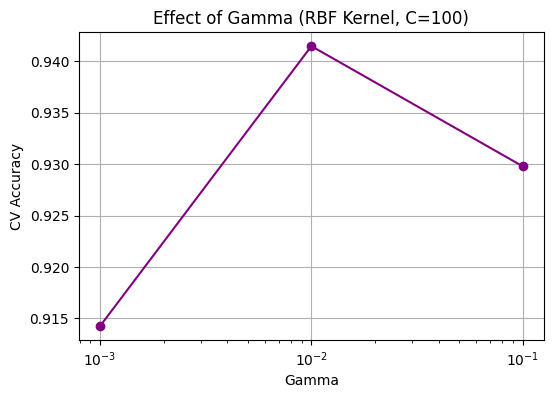


Generating Kernel Comparison Learning Curves (This takes a moment)...


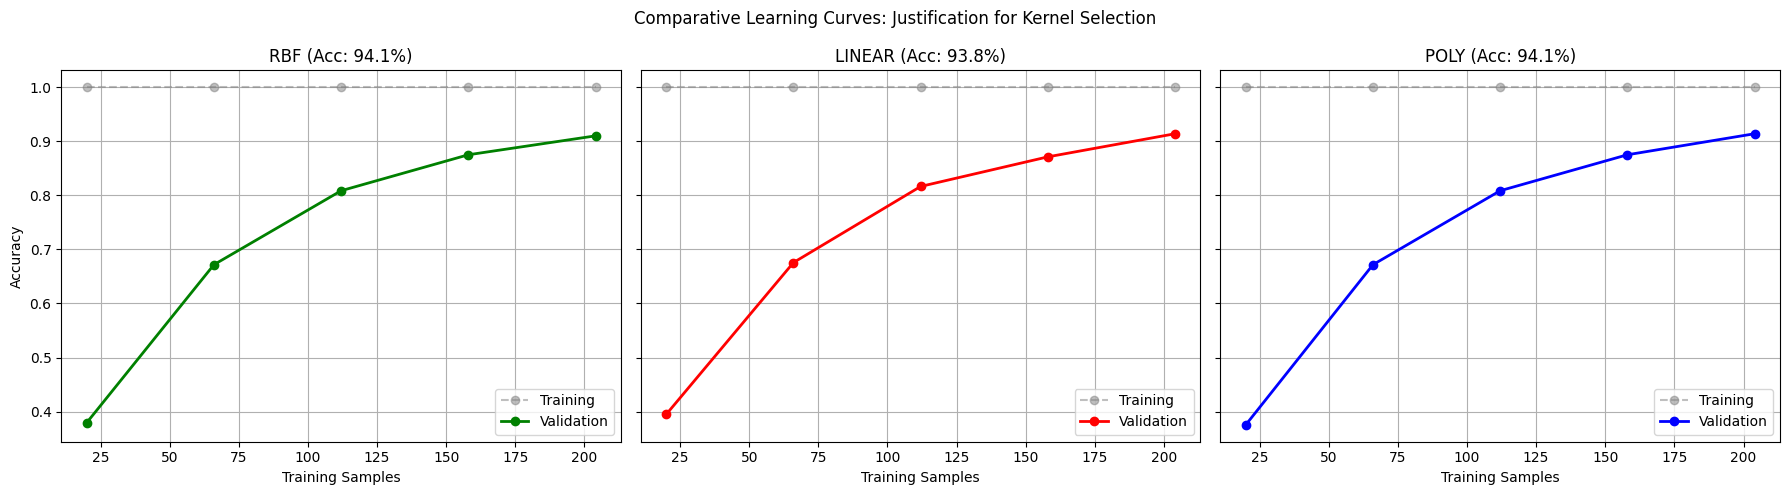

 Best Kernel Found: rbf
 Best Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

FINAL TEST ACCURACY: 76.36%
              precision    recall  f1-score   support

       Angry       1.00      0.67      0.80         9
        Fear       0.64      0.70      0.67        10
       Happy       1.00      0.67      0.80         9
     Neutral       0.90      1.00      0.95         9
         Sad       0.53      1.00      0.69         9
    Surprise       1.00      0.56      0.71         9

    accuracy                           0.76        55
   macro avg       0.84      0.76      0.77        55
weighted avg       0.84      0.76      0.77        55



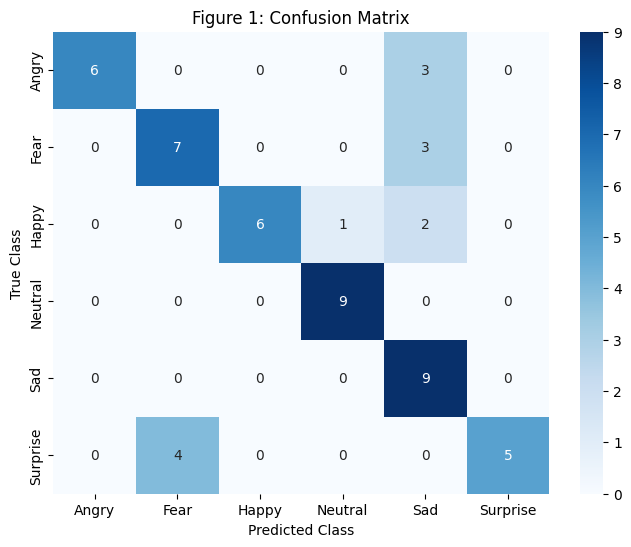

Graph 1 Generated: Confusion Matrix (Check for dark diagonal squares)

Generating Visual Predictions...


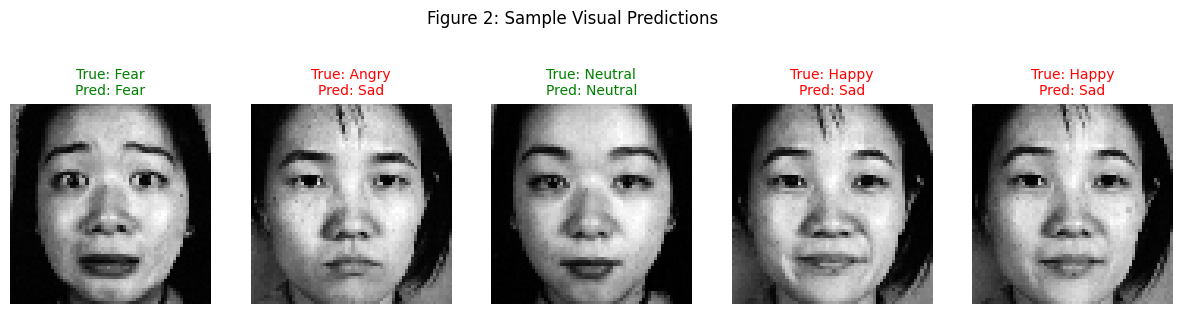

In [27]:
train_path = os.path.join(jaffe_path,'train')
test_path = os.path.join(jaffe_path,'test')
process(train_path, test_path)